# Python MAGIC EMT tutorial

## MAGIC (Markov Affinity-Based Graph Imputation of Cells)

- MAGIC imputes missing data values on sparse data sets, restoring the structure of the data
- It also proves dimensionality reduction and gene expression visualizations
- MAGIC can be performed on a variety of datasets
- Here, we show the effectiveness of MAGIC on epithelial-to-mesenchymal transition (EMT) data
    
Markov Affinity-based Graph Imputation of Cells (MAGIC) is an algorithm for denoising and transcript recover of single cells applied to single-cell RNA sequencing data, as described in Van Dijk D et al. (2018), Recovering Gene Interactions from Single-Cell Data Using Data Diffusion, Cell https://www.cell.com/cell/abstract/S0092-8674(18)30724-4.

This tutorial shows loading, preprocessing, MAGIC imputation and visualization of myeloid and erythroid cells in mouse bone marrow. You can edit it yourself at https://colab.research.google.com/github/KrishnaswamyLab/MAGIC/blob/master/python/tutorial_notebooks/emt_tutorial.ipynb

### Table of Contents

<a href='#install'>Installation</a>
<br/>
<a href='#data'>Loading data</a>
<br/>
<a href='#pre'>Data preprocessing</a>
<br/>
<a href='#magic'>Running MAGIC</a>
<br/>
<a href='#genes'>Visualizing gene-gene interactions</a>
<br/>
<a href='#manifold'>Visualizing cell trajectories with PCA on MAGIC</a>
<br/>
<a href='#postprocess'>Using MAGIC data in downstream analysis</a>

<a id="install"></a>

### Installation 

If you haven't yet installed MAGIC, we can install it directly from this Jupyter Notebook.

In [ ]:
!pip install --user magic-impute

### Importing MAGIC

Here, we'll import MAGIC along with other popular packages that will come in handy.

In [1]:
import magic
import scprep

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Matplotlib command for Jupyter notebooks only
%matplotlib inline

### Loading Data

Load your data using one of the following `scprep.io` methods: `load_csv`,`load_tsv`,`load_fcs`,`load_mtx`,`load_10x`. 

You can read about how to use them with `help(scprep.io.load_csv)` or on https://scprep.readthedocs.io/.

In [2]:
emt_data = scprep.io.load_csv('../../data/HMLE_TGFb_day_8_10.csv.gz', cell_names=False)
emt_data.head()

,5S_rRNA,5_8S_rRNA,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,...,bP-2171C21.6,chr22-38_28785274-29006793.1,pk,snoU109,snoU13,snoU2-30,snoU2_19,snoZ196,uc_338,yR211F11.2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id="data"></a>

### Data Preprocessing

The EMT example data we are using is already pre-filtered and nicely distributed, so we will only demonstrate these preprocessing steps, and not actually perform them on the data. However, these steps are essential for performing MAGIC on **single-cell RNA-seq data**, so don't skip them if that's what you're working with. 

#### Filtering your data

After loading your data, you're going to want to determine the molecule per cell and molecule per gene cutoffs with which to filter the data, in order to remove lowly expressed genes and cells with a small library size.

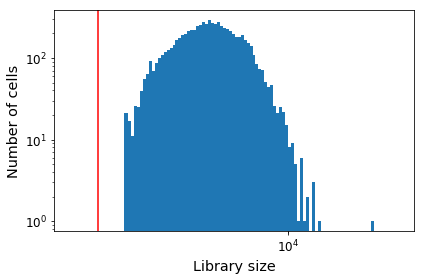

In [3]:
scprep.plot.plot_library_size(emt_data, cutoff=1500)

In [4]:
# be sure to uncomment this, unless your data is pre-filtered
# emt_data = scprep.filter.filter_library_size(emt_data, cutoff=1500)
emt_data.head()

,5S_rRNA,5_8S_rRNA,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,...,bP-2171C21.6,chr22-38_28785274-29006793.1,pk,snoU109,snoU13,snoU2-30,snoU2_19,snoZ196,uc_338,yR211F11.2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Normalizing your data

After filtering, the next steps are to perform library size normalization and transformation. Log transformation is frequently used for single-cell RNA-seq, however, this requires the addition of a pseudocount to avoid infinite values at zero. We instead use a square root transform, which has similar properties to the log transform but has no problem with zeros.

In [5]:
emt_data = scprep.normalize.library_size_normalize(emt_data)
# be sure to uncomment this, unless your data is pre-transformed
# emt_data = scprep.transform.sqrt(emt_data)
emt_data.head()

,5S_rRNA,5_8S_rRNA,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,...,bP-2171C21.6,chr22-38_28785274-29006793.1,pk,snoU109,snoU13,snoU2-30,snoU2_19,snoZ196,uc_338,yR211F11.2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,3.186743,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.131851,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<a id="magic"></a>

### Running MAGIC

Now that your data has been preprocessed, you are ready to run MAGIC.

#### Creating the MAGIC operator

If you don't specify parameters, MAGIC creates an operator with the following default values: `knn=5`, `knn_max = 3 * knn`, `decay=1`, `t=3`.

In [6]:
magic_op = magic.MAGIC()

#### Running MAGIC with gene selection

The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with `genes='all_genes'`.

In [7]:
emt_magic = magic_op.fit_transform(emt_data, genes=['VIM', 'CDH1', 'ZEB1'])

Calculating MAGIC...
  Running MAGIC on 7523 cells and 28910 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 45.72 seconds.
    Calculating KNN search...
    Calculated KNN search in 13.53 seconds.
    Calculating affinities...
    Calculated affinities in 11.80 seconds.
  Calculated graph and diffusion operator in 72.41 seconds.
  Calculating imputation...
Calculated MAGIC in 78.88 seconds.


### Visualizing gene-gene relationships
<a id="genes"></a>

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

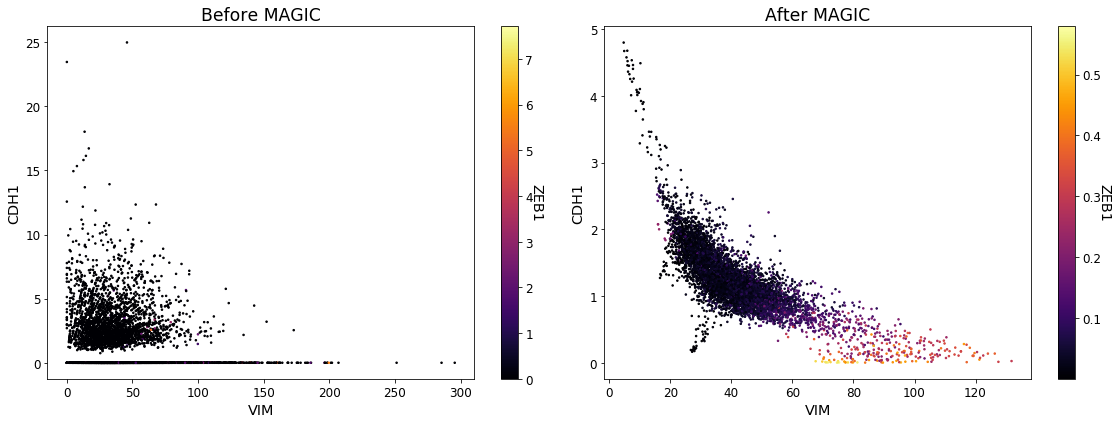

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=emt_data['VIM'], y=emt_data['CDH1'], c=emt_data['ZEB1'],  ax=ax1,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='Before MAGIC')

scprep.plot.scatter(x=emt_magic['VIM'], y=emt_magic['CDH1'], c=emt_magic['ZEB1'], ax=ax2,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='After MAGIC')

plt.tight_layout()
plt.show()

The original data suffers from dropout to the point that we cannot infer anything about the gene-gene relationships. As you can see, the gene-gene relationships are much clearer after MAGIC. These relationships also match the biological progression we expect to see in EMT data.

#### Setting the MAGIC operator parameters

If you did not specify any parameters for your MAGIC operator, you can do so without going through the hassle of creating a new one using the `magic_op.set_params` method. Since our example EMT dataset is rather small, we can set `knn=3`, rather than the default `knn=5`. 



In [9]:
magic_op.set_params(knn=3)

MAGIC(a=None, decay=1, k=None, knn=3, knn_dist='euclidean', knn_max=9, n_jobs=1,
      n_pca=100, random_state=None, solver='exact', t=3, verbose=1)

We can now run MAGIC on the data again with the new parameters. Given that we have already fitted our MAGIC operator to the data, we should run the magic_op.transform method.

In [10]:
emt_magic = magic_op.transform(genes=['VIM', 'CDH1', 'ZEB1'])
emt_magic.head()

Running MAGIC on 7523 cells and 28910 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 44.65 seconds.
  Calculating KNN search...
  Calculated KNN search in 9.11 seconds.
  Calculating affinities...
  Calculated affinities in 8.96 seconds.
Calculated graph and diffusion operator in 64.00 seconds.
Calculating imputation...


,CDH1,VIM,ZEB1
0,1.241728,42.023885,0.009425
1,1.325326,45.031488,0.007015
2,0.929086,53.765334,0.059733
3,1.500046,31.481441,0.017711
4,0.784365,44.139448,0.007882


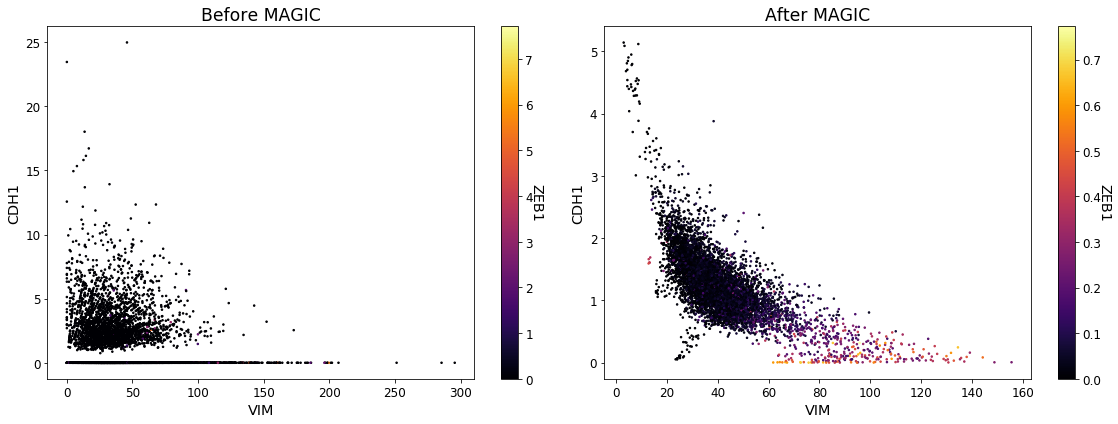

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=emt_data['VIM'], y=emt_data['CDH1'], c=emt_data['ZEB1'],  ax=ax1,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='Before MAGIC')

scprep.plot.scatter(x=emt_magic['VIM'], y=emt_magic['CDH1'], c=emt_magic['ZEB1'], ax=ax2,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='After MAGIC')

plt.tight_layout()
plt.show()

<a id="manifold"></a>

### Visualizing cell trajectories with PCA on MAGIC

We can extract the principal components of the smoothed data by passing the keyword `genes='pca_only'` and use this for visualizing the data.

In [12]:
emt_magic_pca = magic_op.transform(genes='pca_only')
emt_magic_pca.head()

Calculating imputation...
Calculated imputation in 0.07 seconds.


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,0.912814,-18.696491,-22.982646,-32.488871,4.599422,-17.646104,-13.813356,-19.805167,2.388570,-4.619030,...,-0.388829,-0.064307,-0.738726,-0.138937,-0.747050,-0.607294,-0.239226,-0.420499,-0.309441,0.344087
1,7.065558,61.644281,-112.929948,23.018526,1.633835,4.920916,8.173887,-2.396617,-1.942064,-7.829058,...,-0.516180,1.463713,1.153961,1.642654,-0.868328,0.147833,-0.946518,-0.521891,0.853309,-0.239975
2,-12.555619,-57.807529,1.474938,-8.535280,2.626631,-13.697039,2.079862,-1.538081,14.009396,1.824439,...,-0.571415,0.440768,2.178793,-0.892517,-0.366848,0.819920,0.240286,0.517275,0.146062,0.627752
3,-107.818200,160.082200,15.099766,15.106573,-11.030644,7.001513,-11.414310,1.862218,18.806122,-11.505140,...,0.655219,-0.736944,0.257272,-0.551501,1.246661,0.687309,0.079348,0.480107,0.858098,1.597552
4,-15.950164,-25.788197,-56.245822,-29.657388,8.349882,-12.885086,-5.037923,2.962646,-10.603164,-13.955877,...,-2.423693,-0.613807,0.724030,-0.930602,0.730555,1.485058,0.809087,0.875107,-0.036312,1.238325


We'll also run PCA on the raw data to compare.

In [13]:
from sklearn.decomposition import PCA
emt_pca = PCA(n_components=3).fit_transform(np.array(emt_data))

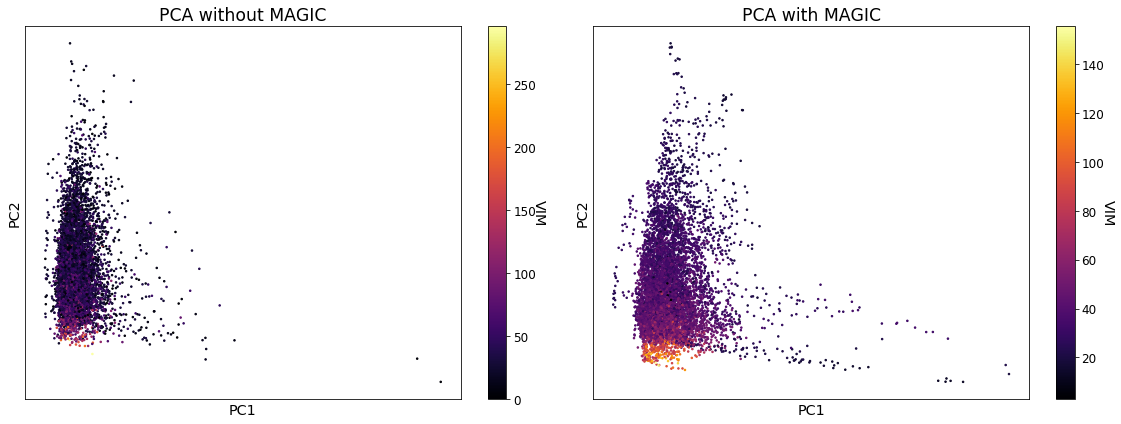

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter2d(emt_pca, c=emt_data['VIM'], 
                      label_prefix="PC", title='PCA without MAGIC',
                      legend_title="VIM", ax=ax1, ticks=False)

scprep.plot.scatter2d(emt_magic_pca, c=emt_magic['VIM'], 
                      label_prefix="PC", title='PCA with MAGIC',
                      legend_title="VIM", ax=ax2, ticks=False)

plt.tight_layout()
plt.show()

We can also plot this in 3D.

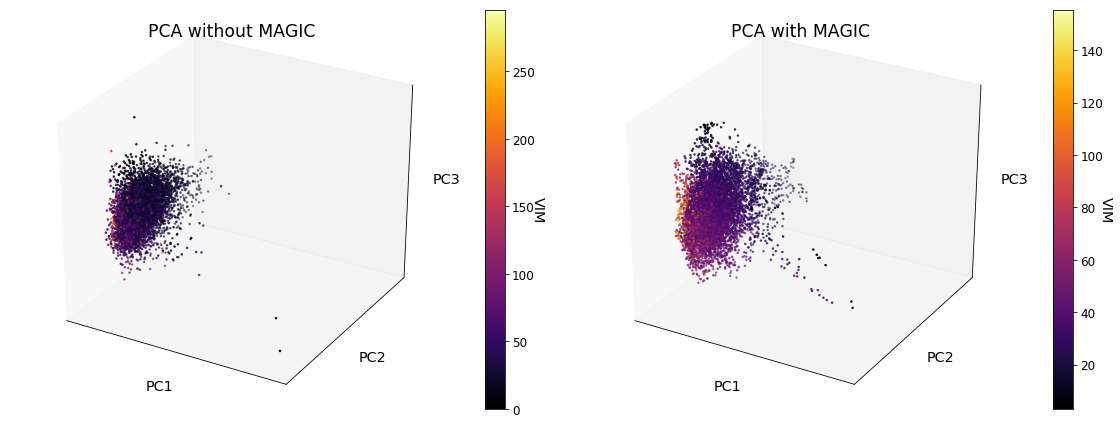

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6), subplot_kw={'projection':'3d'})

scprep.plot.scatter3d(emt_pca, c=emt_data['VIM'], 
                      label_prefix="PC", title='PCA without MAGIC',
                      legend_title="VIM", ax=ax1, ticks=False)

scprep.plot.scatter3d(emt_magic_pca, c=emt_magic['VIM'], 
                      label_prefix="PC", title='PCA with MAGIC',
                      legend_title="VIM", ax=ax2, ticks=False)

plt.tight_layout()
plt.show()

### Visualizing MAGIC values with PHATE

In complex systems, two dimensions of PCA are not sufficient to view the entire space. For this, PHATE is a suitable visualization tool which works hand in hand with MAGIC to view how gene expression evolves along a trajectory. For this, you will need to have installed PHATE. For help using PHATE, visit https://phate.readthedocs.io/.

In [ ]:
!pip install --user phate

In [16]:
import phate

In [17]:
data_phate = phate.PHATE().fit_transform(emt_data)

Calculating PHATE...
  Running PHATE on 7523 cells and 28910 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 45.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 8.18 seconds.
    Calculating affinities...
    Calculated affinities in 0.10 seconds.
  Calculated graph and diffusion operator in 54.60 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.92 seconds.
    Calculating KMeans...
    Calculated KMeans in 38.70 seconds.
  Calculated landmark operator in 41.13 seconds.
  Calculating optimal t...
  Calculated optimal t in 6.97 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.95 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 47.51 seconds.
Calculated PHATE in 154.17 seconds.


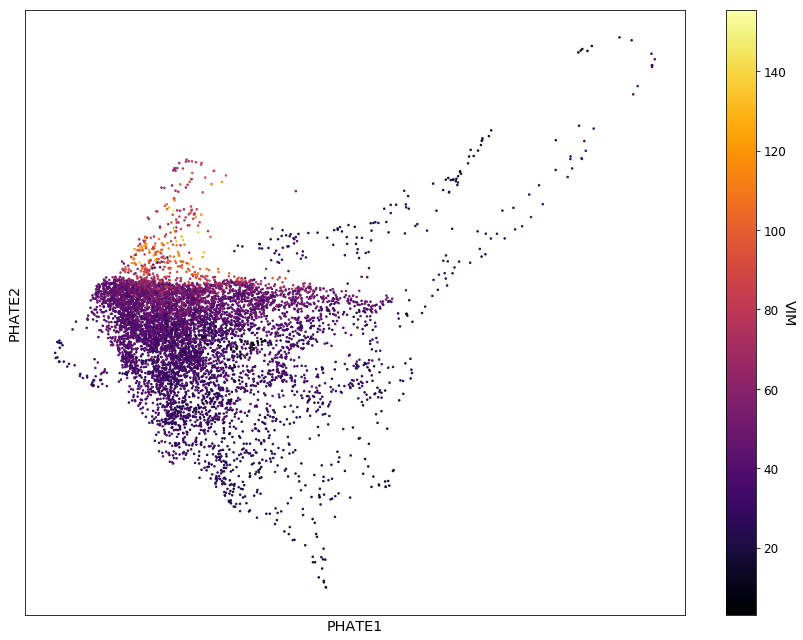

In [18]:
scprep.plot.scatter2d(data_phate, c=emt_magic['VIM'], figsize=(12,9),
                      ticks=False, label_prefix="PHATE", legend_title="VIM")

Note that the structure of the data that we see here is slightly more subtle than in PCA and makes more obvious the VIM+ branch. To learn more about PHATE, visit <https://phate.readthedocs.io/>.

### Exact vs approximate MAGIC

If we are imputing many genes at once, we can speed this process up with the argument `solver='approximate'`, which applies denoising in the PCA space and then projects these denoised principal components back onto the genes of interest. Note that this may return some small negative values. You will see below, however, that the results are largely similar to exact MAGIC.

In [20]:
approx_magic_op = magic.MAGIC(solver="approximate")
approx_emt_magic = approx_magic_op.fit_transform(emt_data, genes='all_genes')

Calculating MAGIC...
  Running MAGIC on 7523 cells and 28910 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 45.21 seconds.
    Calculating KNN search...
    Calculated KNN search in 12.43 seconds.
    Calculating affinities...
    Calculated affinities in 8.88 seconds.
  Calculated graph and diffusion operator in 67.78 seconds.
  Calculating imputation...
  Calculated imputation in 0.12 seconds.
Calculated MAGIC in 78.99 seconds.


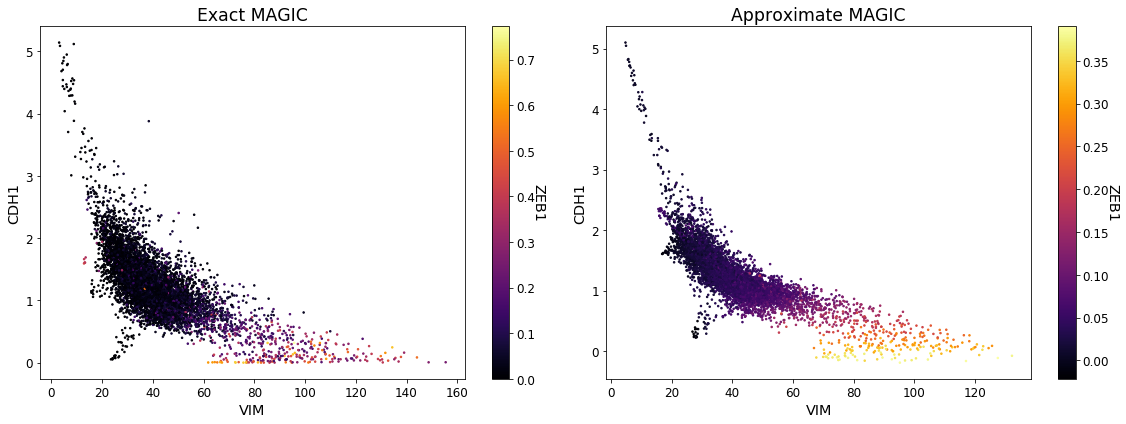

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

scprep.plot.scatter(x=emt_magic['VIM'], y=emt_magic['CDH1'], c=emt_magic['ZEB1'],  ax=ax1,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='Exact MAGIC')

scprep.plot.scatter(x=approx_emt_magic['VIM'], y=approx_emt_magic['CDH1'], c=approx_emt_magic['ZEB1'], ax=ax2,
                    xlabel='VIM', ylabel='CDH1', legend_title="ZEB1", title='Approximate MAGIC')

plt.tight_layout()
plt.show()

### Animating the MAGIC smoothing process

To visualize what it means to set `t` in MAGIC, we can plot an animation of the smoothing process, from raw to imputed values. Below, we show an animation of _Mpo_, _Klf1_ and _Ifitm1_ with increasingly more smoothing.

In [20]:
magic.plot.animate_magic(emt_data, gene_x="VIM", gene_y="CDH1", gene_color="ZEB1",
                         operator=magic_op, t_max=12)

We can also save the animation to a `.gif` file.

In [22]:
# make the font size bigger
plt.rc('font', size=16)
magic.plot.animate_magic(emt_data, gene_x="VIM", gene_y="CDH1", gene_color="ZEB1",
                         operator=magic_op, t_max=12, filename="magic.gif", dpi=300)

### Using the MAGIC smoothed data in downstream analysis
<a id="postprocess"></a>

Finally, if you wish to use the full smoothed matrix in any downstream analysis, you can extract it with the keyword `genes="all_genes"`. Note that this matrix may be very large.

In [23]:
emt_magic = magic_op.transform(genes="all_genes")
emt_magic.head()

,5S_rRNA,5_8S_rRNA,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A4GALT,AAAS,...,bP-2171C21.6,chr22-38_28785274-29006793.1,pk,snoU109,snoU13,snoU2-30,snoU2_19,snoZ196,uc_338,yR211F11.2
0,5.764251e-05,1.533951e-04,0.003434,0.061766,0.000025,4.818677e-07,0.022142,1.013731e-06,0.028264,0.310166,...,0.000050,0.590014,2.812985,0.003020,0.011418,0.000470,0.008308,5.631973e-05,0.050187,0.000001
1,4.580311e-06,3.944496e-05,0.003664,0.059943,0.000041,8.680537e-06,0.023411,2.492076e-06,0.017567,0.311516,...,0.000003,0.568839,2.732127,0.000583,0.021170,0.000034,0.005238,7.709941e-07,0.033117,0.000001
2,5.582967e-05,1.564661e-04,0.002802,0.063171,0.000007,1.509788e-07,0.016387,4.905095e-07,0.030781,0.322526,...,0.000083,0.584983,2.855123,0.004441,0.011834,0.000718,0.007337,1.519939e-04,0.054317,0.000002
3,4.720916e-07,1.636346e-07,0.002893,0.080461,0.000012,1.270483e-03,0.052790,8.470198e-04,0.044647,0.209806,...,0.000050,0.528671,2.770666,0.002443,0.009754,0.000252,0.002916,5.943974e-06,0.026995,0.000342
4,2.949160e-05,1.334564e-04,0.003380,0.063658,0.000010,1.974939e-07,0.016863,2.620986e-07,0.023448,0.314540,...,0.000051,0.607246,2.763649,0.002433,0.011103,0.000332,0.011267,7.097992e-05,0.046243,0.000002


If you wish to export the data, you can do so in many different ways. We recommend the `feather` format, which is fast and lightweight, but `csv` is more commonly used and is compatible with many more software packages.

In [ ]:
!pip install --user feather-format

In [24]:
import feather
feather.write_dataframe(emt_magic, "emt_magic.feather")

In [ ]:
emt_magic.to_csv("emt_magic.csv")